In [4]:
from scipy import io as scio
import numpy as np
import random
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

# Load the Data

In [5]:
# Load the data
Xsp = scio.loadmat("ml_1m.mat")['X']

In [6]:
# Convert to COO format
Xsp = Xsp.tocoo(copy=False)

In [7]:
# Mask
M = Xsp != 0

In [8]:
I, J = np.shape(Xsp)
print("row:", I, "col:", J)
N = np.sum(M) # number of non-zero
print("Number of element:",N)
print("Only", round(N * 100 / (I * J), 2), "% of the matrix is full")

row: 3883 col: 6040
Number of element: 1000209
Only 4.26 % of the matrix is full


In [6]:
data, col, row = Xsp.data, Xsp.col, Xsp.row

# Init the factor matrix

In [7]:
K = 10 #set the rank

W = 1 * np.random.randn(I,K)
H = 1 * np.random.randn(K,J)

# Stochastic gradient descent

In [8]:
batchSize = 1024 #the number of elements that we will use at each iteration

eta = 0.01 #step-size
numIter = 500

rmse_sgd = []

for t in range(numIter):
    
    # get a random batch of index from the data
    data_index = random.sample(range(len(data)), batchSize)
    
    # for each element in the data batch, update the corresponding elements in W and H
    for i in data_index:
        
        # for each element in the batch, find its corresponding 'i', 'j',
        # and value by using the Xlist array
        cur_i = row[i]
        cur_j = col[i]
        cur_x = data[i]
        
       
        # compute the current xhat, for the current i and j
        cur_xhat = W[cur_i, :] @ H[:, cur_j]

        # compute the gradients for the 'corresponding elements' of W and H
        # not all the elements of W and H will be updated
        cur_W = W[cur_i, :]
        cur_H = H[:, cur_j]
        O = np.ones((K, K))
        
        grad_w = (cur_x - cur_W @ cur_H) * cur_H.T
        grad_h = cur_W.T * (cur_x - cur_W @ cur_H)
        
        #take a gradient step
        W[cur_i,:] = W[cur_i,:] + eta * grad_w
        H[:,cur_j] = H[:,cur_j] + eta * grad_h
    
    # compute the root-mean-squared error
    error = np.sqrt((Xsp - M.multiply(W.dot(H))).power(2).sum() / N)
    rmse_sgd.append(error)
    print('Iteration',t)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

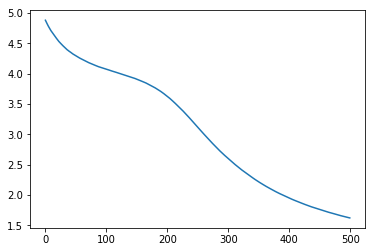

In [9]:
sns.lineplot(y = rmse_sgd, x = range(len(rmse_sgd)))

# Make recommendations

In [10]:
# Compute the predicted X using the estimated W and H matrix
predicted_X = W @ H

user_index = 11

# Use W, H, and M to compute a 'movie_index' for the user
# Get the rating for all movies corresponding to this user
movies = predicted_X[:, user_index].reshape(-1, 1)

# Filter out all movies that are seen by this user
unseen_M = M[:, user_index].toarray()
unseen_movies = unseen_M * movies

# Recommend the unseen movie with largest rating to the current user
recommend_movie_index = np.argmax(unseen_movies)

print('Recommend movie', recommend_movie_index,'to user', user_index)
print("rating", unseen_movies[recommend_movie_index][0])



Recommend movie 907 to user 11
rating 3.211889103425637


# Experiments

## Wrap the Stochastic gradient descent into function for future experiment

In [2]:
def SGD(Xsp, batchSize = 1024, eta = 0.01, numIter = 500, K = 10, seed = 1):
    
    data, col, row = Xsp.data, Xsp.col, Xsp.row
    W = seed * np.random.randn(I,K)
    H = seed * np.random.randn(K,J)
    
    rmse_sgd = []

    for t in range(numIter):

        # get a random batch of index from the data
        data_index = random.sample(range(len(data)), batchSize)

        # for each element in the data batch, update the corresponding elements in W and H
        for i in data_index:

            # for each element in the batch, find its corresponding 'i', 'j',
            # and value by using the Xlist array
            cur_i = row[i]
            cur_j = col[i]
            cur_x = data[i]


            # compute the current xhat, for the current i and j
            cur_xhat = W[cur_i, :] @ H[:, cur_j]

            # compute the gradients for the 'corresponding elements' of W and H
            # not all the elements of W and H will be updated
            cur_W = W[cur_i, :]
            cur_H = H[:, cur_j]
            O = np.ones((K, K))

            grad_w = (cur_x - cur_W @ cur_H) * cur_H.T
            grad_h = cur_W.T * (cur_x - cur_W @ cur_H)

            #take a gradient step
            W[cur_i,:] = W[cur_i,:] + eta * grad_w
            H[:,cur_j] = H[:,cur_j] + eta * grad_h

        # compute the root-mean-squared error
        error = np.sqrt((Xsp - M.multiply(W.dot(H))).power(2).sum() / N)
        rmse_sgd.append(error)
    return W, H, rmse_sgd

In [3]:
def predict(W, H, user_index):
    # Compute the predicted X using the estimated W and H matrix
    predicted_X = W @ H

    # Use W, H, and M to compute a 'movie_index' for the user
    # Get the rating for all movies corresponding to this user
    movies = predicted_X[:, user_index].reshape(-1, 1)

    # Filter out all movies that are seen by this user
    unseen_M = M[:, user_index].toarray()
    unseen_movies = unseen_M * movies

    # Recommend the unseen movie with largest rating to the current user
    recommend_movie_index = np.argmax(unseen_movies)
    rating = unseen_movies[recommend_movie_index][0]
    
    return recommend_movie_index, rating



## Step-size

In [53]:
step_sizes = [0.0001, 0.001, 0.01, 0.1 , 0.2]
rmse_sgds = dict() 
for step_size in step_sizes:
    user_index = 11
    W, H, rmse_sgd = SGD(Xsp, eta = step_size, numIter=200)
    movie_index, rating = predict(W, H, user_index=user_index)
    rmse_sgds[step_size] = rmse_sgd
    
    print("============\nStep size: ", step_size)
    print('Recommend movie', movie_index,'to user', user_index)
    print("rating", rating)

Step size:  0.0001
Recommend movie 847 to user 11
rating 3.0898743843494865
Step size:  0.001
Recommend movie 3589 to user 11
rating 5.391674198718128
Step size:  0.01
Recommend movie 3589 to user 11
rating 5.156665646485279


/home/quan/.local/lib/python3.6/site-packages/scipy/sparse/data.py:116: RuntimeWarning: overflow encountered in square
  return self._with_data(data ** n)
/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in add


Step size:  0.1
Recommend movie 0 to user 11
rating nan


/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


Step size:  0.2
Recommend movie 0 to user 11
rating nan


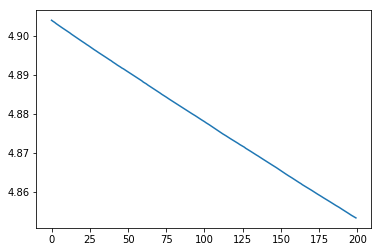

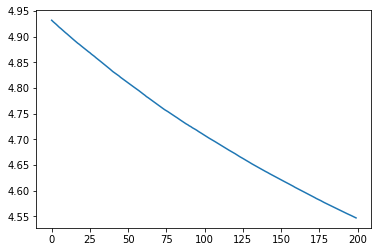

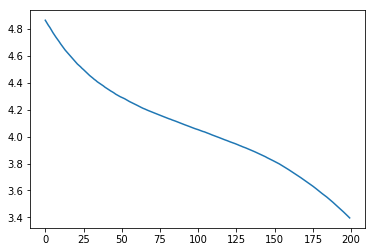

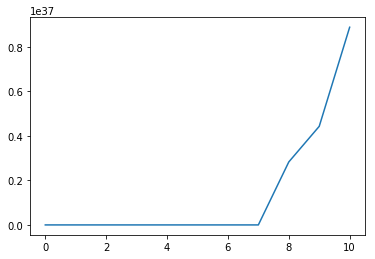

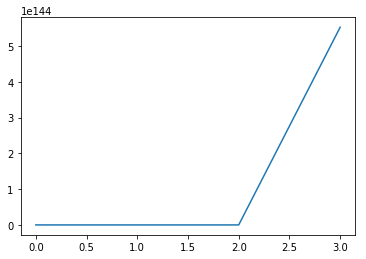

In [54]:
data = pd.DataFrame.from_dict(rmse_sgds)
for step_size in step_sizes:
    sns.lineplot(data=data[step_size])
    plt.show()

## Batch-size

In [62]:
batch_sizes = [1, 8, 64, 256, 2048, 5096]
batch_rmse_sgds = dict() 
for batch_size in batch_sizes:
    user_index = 11
    W, H, rmse_sgd = SGD(Xsp, batchSize=batch_size, numIter=200)
    movie_index, rating = predict(W, H, user_index=user_index)
    batch_rmse_sgds[batch_size] = rmse_sgd
    print("============\nBatch size: ", batch_size)
    print('Recommend movie', movie_index,'to user', user_index)
    print("rating", rating)

Batch size:  1
Recommend movie 1203 to user 11
rating 4.422540835432788
Batch size:  8
Recommend movie 986 to user 11
rating 3.0562203126060212
Batch size:  64
Recommend movie 3589 to user 11
rating 10.31744161406455
Batch size:  256
Recommend movie 803 to user 11
rating 6.858907609419307
Batch size:  2048
Recommend movie 1180 to user 11
rating 3.885229322057326
Batch size:  5096
Recommend movie 1232 to user 11
rating 4.0131428990358335


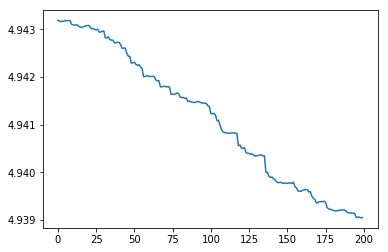

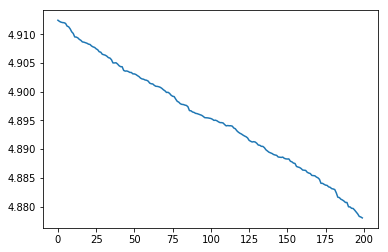

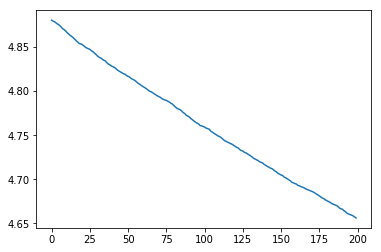

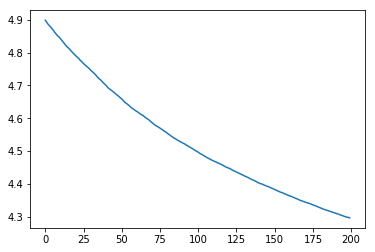

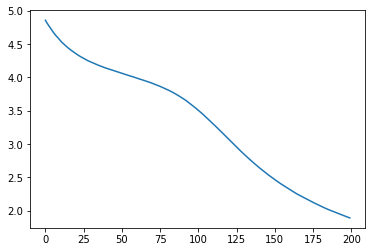

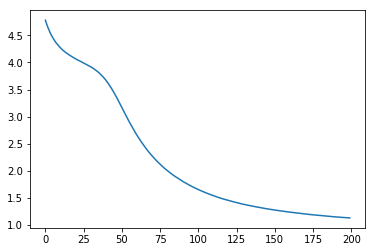

In [63]:
data = pd.DataFrame.from_dict(batch_rmse_sgds)
for batch_size in batch_sizes:
    sns.lineplot(data=data[batch_size])
    plt.show()

## Compare the SGD using same amount of processing data
- Batch-size = 1000 and num of iterations = 100: amount of processing data = 100 * 1000 = 100,000
- Batch-size = 100 and num of iterations = 1000: amount of processing data = 1000 * 100 = 100,000

In [15]:
params = [(1000, 100), (100, 1000)]
rmse_sgds = dict() 
for batch_size, numIters in params:
    user_index = 11
    W, H, rmse_sgd = SGD(Xsp, batchSize=batch_size,numIter=numIters)
    movie_index, rating = predict(W, H, user_index=user_index)
    rmse_sgds["batch-size=" + str(batch_size) + ", numIters=" + str(step_size)] = rmse_sgd
    print("============\nBatch size: ", batch_size)
    print("Step numIters: ", numIters)
    print('Recommend movie', movie_index,'to user', user_index)
    print("rating", rating)

Batch size:  1000
Step numIters:  100
Recommend movie 3589 to user 11
rating 6.734066953962967
Batch size:  100
Step numIters:  1000
Recommend movie 803 to user 11
rating 3.368460580566631


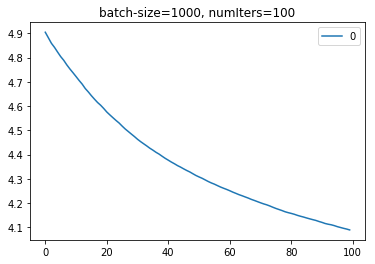

Error of the last iteration:  4.088916472118226
Error of the first iteration:  4.904622119921359


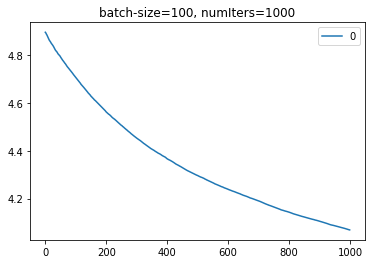

Error of the last iteration:  4.069258790702814
Error of the first iteration:  4.895025474263158


In [18]:
for batch_size, numIters in params:
    key = "batch-size=" + str(batch_size) + ", numIters=" + str(step_size)
    data = pd.DataFrame(rmse_sgds[key])
    sns.lineplot(data=data)
    plt.title("batch-size=" + str(batch_size) + ", numIters=" + str(numIters))
    plt.show()
    print("Error of the last iteration: ", rmse_sgds[key][-1])
    print("Error of the first iteration: ", rmse_sgds[key][0])

## Rank of the factorization

In [67]:
ranks = [10, 20, 40, 80, 160, 320]
rank_rmse_sgds = dict() 
for rank in ranks:
    user_index = 11
    W, H, rmse_sgd = SGD(Xsp, K=rank, numIter=200)
    movie_index, rating = predict(W, H, user_index=user_index)
    rank_rmse_sgds[rank] = rmse_sgd
    print("============\nRank: ", rank)
    print('Recommend movie', movie_index,'to user', user_index)
    print("rating", rating)

Rank:  10
Recommend movie 2547 to user 11
rating 3.053689507105041
Rank:  20
Recommend movie 922 to user 11
rating 5.241099716821062
Rank:  40
Recommend movie 1180 to user 11
rating 6.307523151929772
Rank:  80
Recommend movie 3827 to user 11
rating 9.173449089899227
Rank:  160
Recommend movie 3827 to user 11
rating 14.934237023311614


/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


Rank:  320
Recommend movie 0 to user 11
rating nan


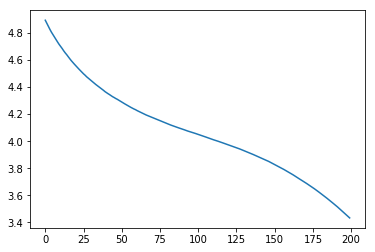

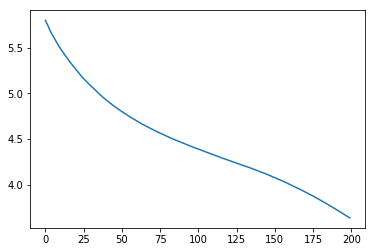

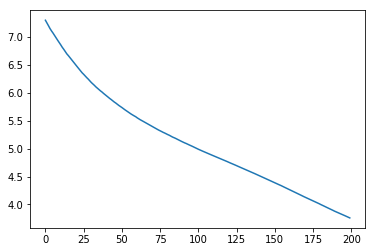

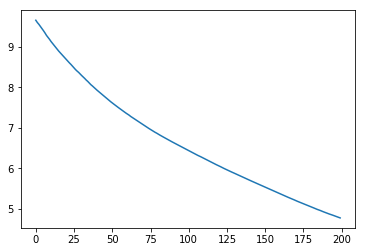

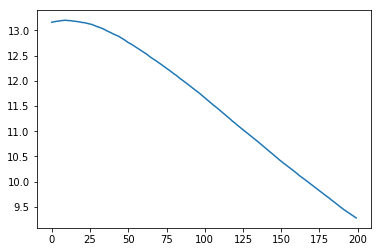

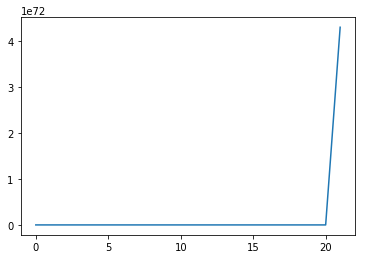

In [68]:
data = pd.DataFrame.from_dict(rank_rmse_sgds)
for rank in ranks:
    sns.lineplot(data=data[rank])
    plt.show()

### If we use the rank = 320 with smaller step-size 0.001, the SGD can convert to minima.

Rank:  320
Recommend movie 847 to user 11
rating 27.149957010128304


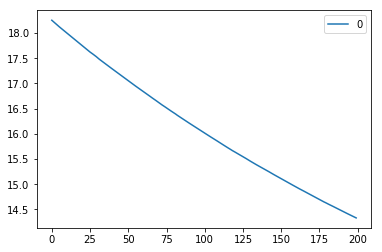

In [90]:
user_index = 11
W, H, rmse_sgd = SGD(Xsp, K=320, numIter=200, eta=0.001)
movie_index, rating = predict(W, H, user_index=user_index)
print("============\nRank: 320")
print('Recommend movie', movie_index,'to user', user_index)
print("rating", rating)
sns.lineplot(data=pd.DataFrame(rmse_sgd))
plt.show()

## Change the initialization

In [72]:
seeds = [1, 2, 3, 4, 5]
seed_rmse_sgds = dict() 
for seed in seeds:
    user_index = 11
    W, H, rmse_sgd = SGD(Xsp, seed=seed, numIter=200)
    movie_index, rating = predict(W, H, user_index=user_index)
    seed_rmse_sgds[seed] = rmse_sgd
    print("============\nSeed: ", seed)
    print('Recommend movie', movie_index,'to user', user_index)
    print("rating", rating)

Seed:  1
Recommend movie 589 to user 11
rating 0.9179795479582955
Seed:  2
Recommend movie 1283 to user 11
rating 7.946398663729055
Seed:  3
Recommend movie 1180 to user 11
rating 8.147596799840652


/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/home/quan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


Seed:  4
Recommend movie 0 to user 11
rating nan
Seed:  5
Recommend movie 0 to user 11
rating nan


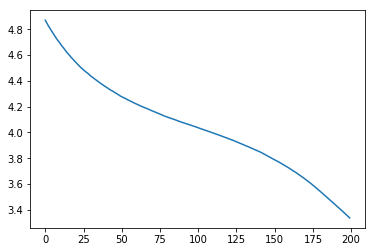

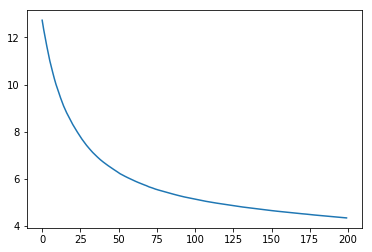

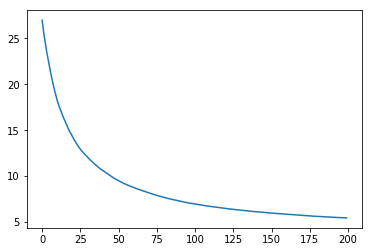

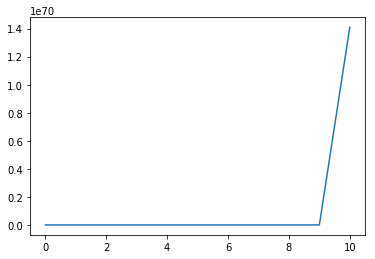

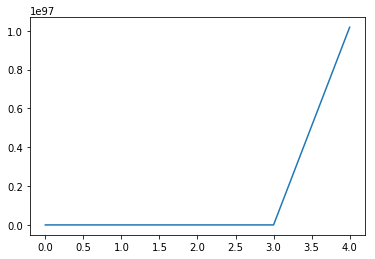

In [74]:
data = pd.DataFrame.from_dict(seed_rmse_sgds)
for seed in seeds:
    sns.lineplot(data=data[seed])
    plt.show()

Seed:  4
Recommend movie 3196 to user 11
rating 68.9845078396439


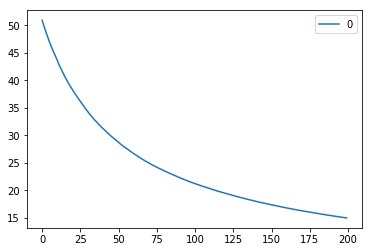

In [91]:
seed = 4
user_index = 11
W, H, rmse_sgd = SGD(Xsp, seed=seed, numIter=200, eta=0.001)
movie_index, rating = predict(W, H, user_index=user_index)
print("============\nSeed: ", seed)
print('Recommend movie', movie_index,'to user', user_index)
print("rating", rating)
sns.lineplot(data=pd.DataFrame(rmse_sgd))
plt.show()

## Interaction between batch-size and step-size

In [100]:
batch_sizes = [1, 10, 100]
step_sizes = [0.0001, 0.001, 0.01]
interact_rmse_sgds = dict() 
for batch_size in batch_sizes:
    for step_size in step_sizes:
        user_index = 11
        W, H, rmse_sgd = SGD(Xsp, batchSize=batch_size, eta=step_size, numIter=200)
        movie_index, rating = predict(W, H, user_index=user_index)
        interact_rmse_sgds["batch_size=" + str(batch_size) + ", step_size=" + str(step_size)] = rmse_sgd
        print("============\nBatch size: ", batch_size)
        print("Step size: ", step_size)
        print('Recommend movie', movie_index,'to user', user_index)
        print("rating", rating)

Batch size:  1
Step size:  0.0001
Recommend movie 911 to user 11
rating 6.648051441212179
Batch size:  1
Step size:  0.001
Recommend movie 3293 to user 11
rating 4.2069193659193225
Batch size:  1
Step size:  0.01
Recommend movie 1214 to user 11
rating 8.011211728717267
Batch size:  10
Step size:  0.0001
Recommend movie 1203 to user 11
rating 8.40805458294971
Batch size:  10
Step size:  0.001
Recommend movie 2735 to user 11
rating 3.4829558402670666
Batch size:  10
Step size:  0.01
Recommend movie 589 to user 11
rating 5.918298656905912
Batch size:  100
Step size:  0.0001
Recommend movie 1214 to user 11
rating 11.639152667175154
Batch size:  100
Step size:  0.001
Recommend movie 1283 to user 11
rating 9.217041757192334
Batch size:  100
Step size:  0.01
Recommend movie 109 to user 11
rating 1.8262317471466911


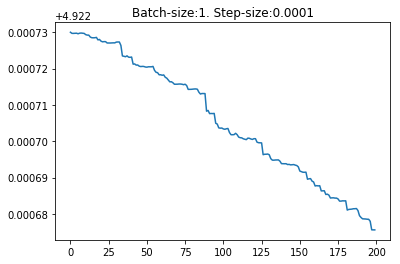

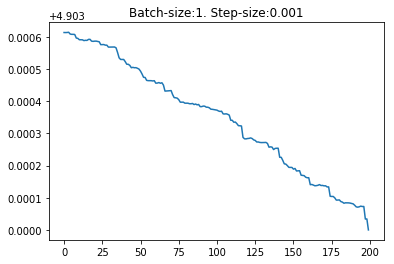

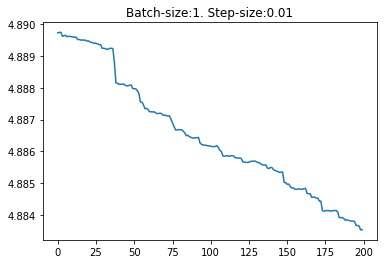

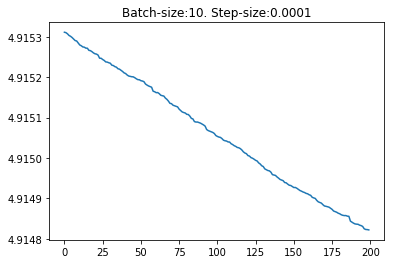

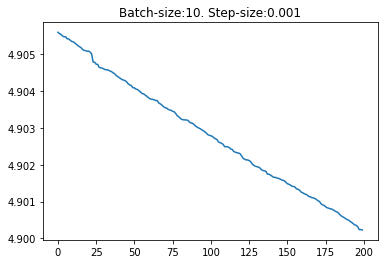

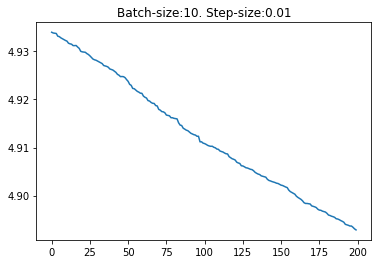

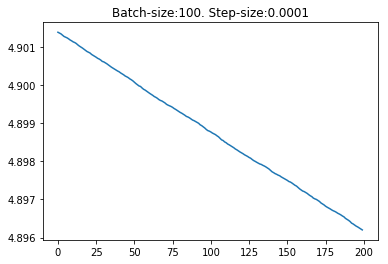

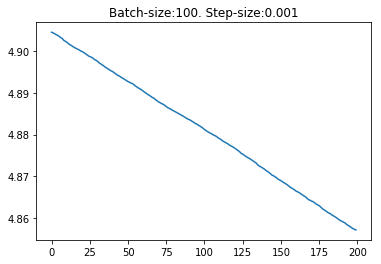

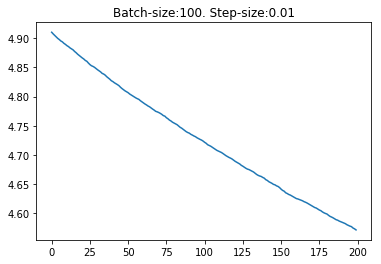

In [101]:
data = pd.DataFrame.from_dict(interact_rmse_sgds)
for batch_size in batch_sizes:
    for step_size in step_sizes:
        sns.lineplot(data=data["batch_size=" + str(batch_size) + ", step_size=" + str(step_size)])
        plt.title("Batch-size:" + str(batch_size) + ". Step-size:" + str(step_size))
        plt.show()

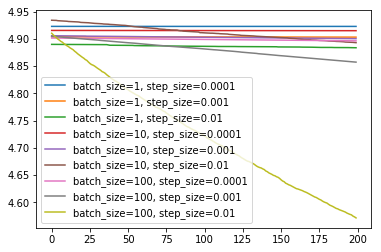

In [103]:
sns.lineplot(data=data, dashes=False)

In [104]:
data.head()

,"batch_size=1, step_size=0.0001","batch_size=1, step_size=0.001","batch_size=1, step_size=0.01","batch_size=10, step_size=0.0001","batch_size=10, step_size=0.001","batch_size=10, step_size=0.01","batch_size=100, step_size=0.0001","batch_size=100, step_size=0.001","batch_size=100, step_size=0.01"
0,4.92273,4.903613,4.889724,4.915311,4.905593,4.933988,4.901389,4.904542,4.910173
1,4.92273,4.903613,4.889733,4.915310,4.905555,4.933833,4.901369,4.904398,4.907272
2,4.92273,4.903613,4.889740,4.915308,4.905536,4.933773,4.901346,4.904187,4.904699
3,4.92273,4.903614,4.889614,4.915303,4.905493,4.933733,4.901312,4.903982,4.902341
4,4.92273,4.903609,4.889627,4.915301,4.905471,4.933165,4.901278,4.903796,4.899569


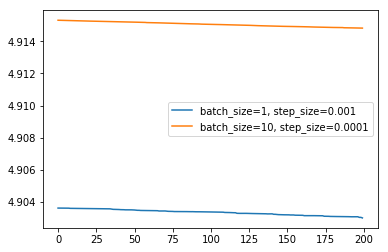

In [107]:
sns.lineplot(data=data[['batch_size=1, step_size=0.001', 'batch_size=10, step_size=0.0001']], dashes=False)

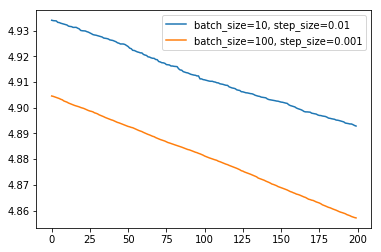

In [108]:
sns.lineplot(data=data[['batch_size=10, step_size=0.01', 'batch_size=100, step_size=0.001']], dashes=False)

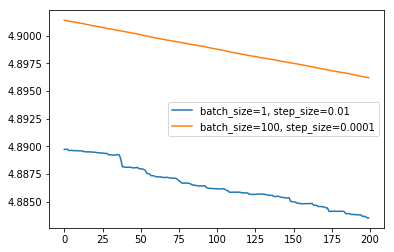

In [110]:
sns.lineplot(data=data[['batch_size=1, step_size=0.01', 'batch_size=100, step_size=0.0001']], dashes=False)

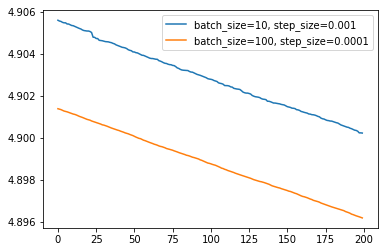

In [111]:
sns.lineplot(data=data[['batch_size=10, step_size=0.001', 'batch_size=100, step_size=0.0001']], dashes=False)